<a href="https://colab.research.google.com/github/noprisigit/ResNet50/blob/main/ResNet50%20-%2024/05/2025%20-%20BS%2032%2C%20LR%200%2C001%2C%20EP%2050.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cervical Lesion Classification with ResNet50 in Google Colab

## Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## Step 2: Extract ZIP Dataset from Google Drive
import zipfile
import os

# zip_path = '/content/drive/MyDrive/dataset-swedesh-score.zip'  # Ganti path ini sesuai lokasi ZIP Anda
# extract_path = '/content/dataset-swedesh-score'

# if not os.path.exists(extract_path):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_path)
#     print("Dataset extracted successfully.")
# else:
#     print("Dataset already extracted.")
!unzip '/content/drive/MyDrive/dataset-swedesh-score-tanpa-normal-30.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dataset-swedesh-score-tanpa-normal-30/train/CIN 2/C92Aceto (2)_aug27.jpg  
  inflating: dataset-swedesh-score-tanpa-normal-30/train/CIN 2/C92Aceto (2)_aug28.jpg  
  inflating: dataset-swedesh-score-tanpa-normal-30/train/CIN 2/C92Aceto (2)_aug29.jpg  
  inflating: dataset-swedesh-score-tanpa-normal-30/train/CIN 2/C92Aceto (2)_aug3.jpg  
  inflating: dataset-swedesh-score-tanpa-normal-30/train/CIN 2/C92Aceto (2)_aug30.jpg  
  inflating: dataset-swedesh-score-tanpa-normal-30/train/CIN 2/C92Aceto (2)_aug31.jpg  
  inflating: dataset-swedesh-score-tanpa-normal-30/train/CIN 2/C92Aceto (2)_aug32.jpg  
  inflating: dataset-swedesh-score-tanpa-normal-30/train/CIN 2/C92Aceto (2)_aug33.jpg  
  inflating: dataset-swedesh-score-tanpa-normal-30/train/CIN 2/C92Aceto (2)_aug34.jpg  
  inflating: dataset-swedesh-score-tanpa-normal-30/train/CIN 2/C92Aceto (2)_aug35.jpg  
  inflating: dataset-swedesh-score-tanpa-normal-30/train/CIN 2/C92Acet

In [2]:
## Step 3: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight

## Step 4: Define Paths and Parameters
data_dir = '/content/dataset-swedesh-score-tanpa-normal-30'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
img_size = (224, 224)
batch_size = 32
n_classes = 3
class_names = ['CIN 1', 'CIN 2', 'CIN 3']

In [3]:
## Step 5: Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 14451 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


In [4]:
## Step 6: Build Model with Pretrained
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = True

# Compile model
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9, decay=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [5]:
## Step 7: Train Model
labels = train_generator.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    # class_weight=class_weights,
    # callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 299s 563ms/step - accuracy: 0.6741 - loss: 0.7230 - val_accuracy: 0.3617 - val_loss: 1.1519
Epoch 2/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 234s 517ms/step - accuracy: 0.9821 - loss: 0.0547 - val_accuracy: 0.4326 - val_loss: 1.8931
Epoch 3/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 233s 516ms/step - accuracy: 0.9898 - loss: 0.0297 - val_accuracy: 0.7660 - val_loss: 1.2114
Epoch 4/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 231s 510ms/step - accuracy: 0.9891 - loss: 0.0245 - val_accuracy: 0.7801 - val_loss: 1.0200
Epoch 5/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 262s 509ms/step - accuracy: 0.9930 - loss: 0.0173 - val_accuracy: 0.7801 - val_loss: 1.0495
Epoch 6/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 265s 516ms/step - accuracy: 0.9944 - loss: 0.0133 - val_accuracy: 0.7730 - val_loss: 1.1686
Epoch 7/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 233s 515ms/step - accuracy: 0.9945 - loss: 0.0110 - val_accuracy: 0.7872 - val_loss: 1.1479
Epoch 8/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 234s 517ms/step - accuracy: 0.9933 -

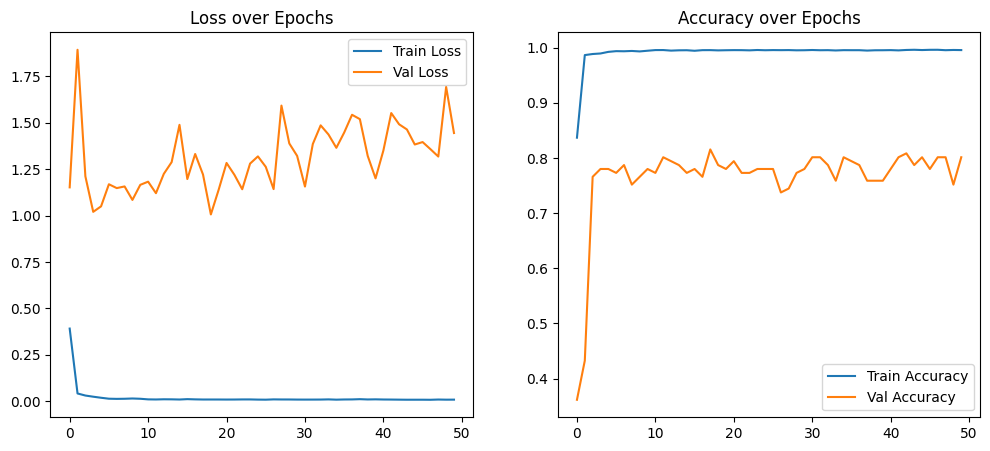

In [6]:
## Step 8: Plot Loss and Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


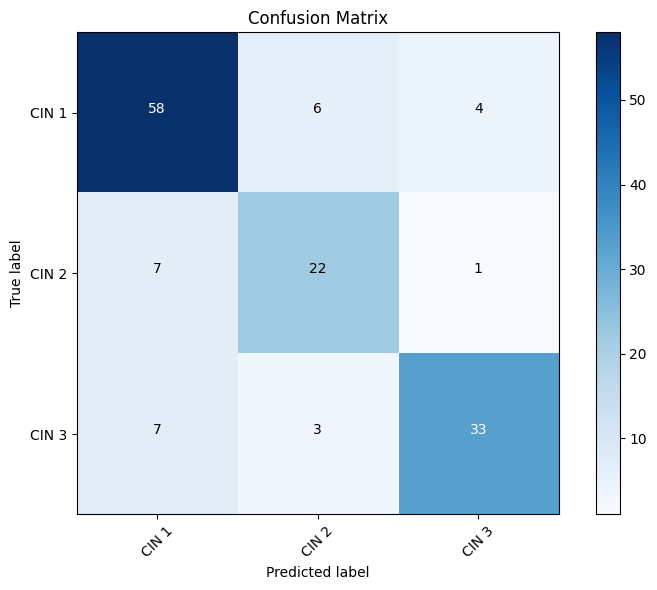

              precision    recall  f1-score   support

       CIN 1       0.81      0.85      0.83        68
       CIN 2       0.71      0.73      0.72        30
       CIN 3       0.87      0.77      0.81        43

    accuracy                           0.80       141
   macro avg       0.79      0.78      0.79       141
weighted avg       0.80      0.80      0.80       141



In [7]:
## Step 9: Confusion Matrix and Classification Report
# Predict
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

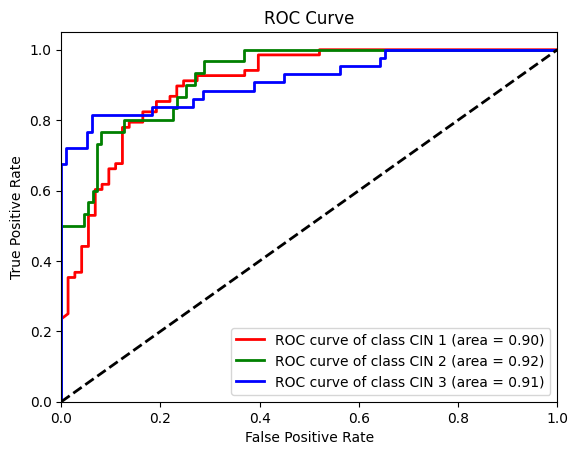

In [8]:
## Step 10: ROC Curve
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure()
colors = ['red', 'green', 'blue', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()